# Face features detection and dog nose overlay
This notebook describes the the steps taken to implement snapchat-like nose overlay feature.
This implementation required some exploring of a face features detection model,specifically the nose.   
I used the [Kaggle keypoints detection data](https://www.kaggle.com/c/facial-keypoints-detection) and [referenced blog by Daniel Nouri](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/) to explore this model.   
    
___
* [Step 0](#step0): Exploring the data
* [Step 1](#step1): Play a little with overlaying pictures
* [Step 2](#step2): Train a node detection CNN
* [Step 3](#step3): Putting it all together
* [Step 4](#Step4): Augmenting training data with keypoints

<a id='step0'></a>
## Step 0: Explore the data
First thing first, let's explore the data and labels.
I'll start with loading the data from CSV and inspecting structure and examples

In [10]:
import os
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import random 
from IPython.core.display import display
from PIL import Image

FTRAIN = 'face_detection/facial-keypoint-detection/training.csv'
FTEST = 'face_detection/facial-keypoint-detection/test.csv'

In [11]:
df = read_csv(os.path.expanduser(FTRAIN))
df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


There are many facial features, I only care about nose detection and the image itself

In [17]:
#convert CSV column from string to array of numbers
df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

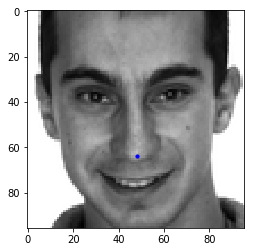

In [5]:
img_ind=random.randint(0,df.shape[0])
plt.figure()
#The "flat" array is actually 96 by 96 pixels so it needs numpy reshaping
plt.imshow(df['Image'][img_ind].reshape(96,96), cmap='gray')
#also wanted to plot the tagged nose location 
plt.scatter(df['nose_tip_x'][img_ind], df['nose_tip_y'][img_ind], s=10, c='blue', marker='o')
plt.show()

<a id='step1'></a>
## Step 0: Play a little with overlaying pictures
I've downloaded a dog nose drawing I found on [favim.com](http://favim.com/image/4075915/) and cropped the nose only and reduced its size

(35, 58, 3)


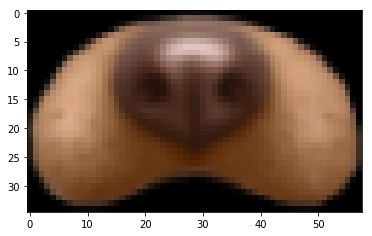

In [674]:
nose_img = np.array(Image.open("dognose_small.png"))[:,:,:3]
print(nose_img.shape)
plt.imshow(nose_img)

One way to overlay the nose drawing on top of an image, is using the Pillow library which has some utilities to achieve that. However, it was harder than I thought it would be, plus, I wanted to experiment altering the numpy image array.    
    
Function to transform grayscale to RGB So I can overlay RGB images. I found this function [here](http://www.socouldanyone.com/2013/03/converting-grayscale-to-rgb-with-numpy.html)


In [10]:
def to_rgb(im):
    w, h = im.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = im
    ret[:, :, 1] = ret[:, :, 2] = ret[:, :, 0]
    return ret

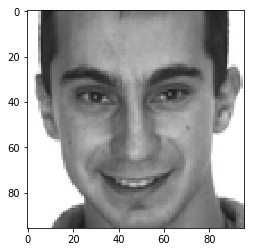

In [11]:
#assign and display to see the transformation was successful
rgb_img = to_rgb(df['Image'][img_ind].reshape(96,96))
plt.imshow(rgb_img)

Finally, I will overlay one image on top of another.   
I used numpy slicing to "override" a portion of the image. this first caused a black box the size of the nose image edges where zeros overrides the original image.    in order to avoid that, I used numpy [where](https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html) to ignore cases where the nose image has zeros

(19, 77, 47, 82)


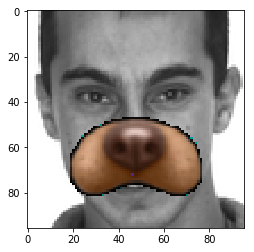

In [47]:
#calculate nose image box
x_box = int(round(df['nose_tip_x'][img_ind] - nose_img.shape[1]//2,0))
y_box = int(round(df['nose_tip_y'][img_ind] - nose_img.shape[0]//2,0))
x_size = x_box + nose_img.shape[1]
y_size = y_box + nose_img.shape[0]
print(x_box, x_size, y_box, y_size)
#override the original image with dog nose image and ignore dog nose zeros
rgb_img[y_box:y_size, x_box:x_size] = np.where(nose_img == 0, rgb_img[y_box:y_size, x_box:x_size], nose_img)
plt.imshow(rgb_img)

This is kind of ugly because of the rough edges and I'm sure there are better ways to achieve this overlay such as alpha channel overlay, but I'm stopping here so I can move to training the nose detector.
___

<a id='step2'></a>
## Step 2:Creating a nose detection CNN 

The problem at hand is a regression problem, So the model is a mini-VGG stype CNN model, with no nonlinear activation at the final output layer, and root-mean-squared-error loss function

In [598]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense,Activation
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(96, 96, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 94, 94, 32)        320       
_________________________________________________________________
activation_58 (Activation)   (None, 94, 94, 32)        0         
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_65 (Dropout)         (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
activation_59 (Activation)   (None, 45, 45, 64)        0         
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 22, 22, 64)        0         
__________

In [599]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [600]:
#code taken from nouri's blog
X = np.vstack(df['Image'].values) / 255  # scale pixel values to [0, 1]
X = X.astype(np.float32)
X = X.reshape(-1, 96, 96, 1)
y = df[['nose_tip_x','nose_tip_y']].values
y = (y - 48) / 48  # scale target coordinates to [-1, 1]
X, y = shuffle(X, y, random_state=42)  # shuffle train data
y = y.astype(np.float32)

In [601]:
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

X.shape == (7049, 96, 96, 1); X.min == 0.000; X.max == 1.000
y.shape == (7049, 2); y.min == -0.730; y.max == 0.999


In [602]:
from keras.callbacks import ModelCheckpoint  
from sklearn.model_selection import train_test_split

epochs = 100

#X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.20, random_state=42)
        
checkpointer = ModelCheckpoint(filepath='saved_models/face.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

faces_run = model.fit(X, y,
                      nb_epoch=epochs, 
                      validation_split=0.2,
                      batch_size=64, 
                      callbacks=[checkpointer], 
                      verbose=1)

/home/ubuntu/py27/local/lib/python2.7/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 5639 samples, validate on 1410 samples
Epoch 1/100
5639/5639 [==============================] - 9s 2ms/step - loss: 0.0590 - val_loss: 0.0157
Epoch 2/100
5639/5639 [==============================] - 7s 1ms/step - loss: 0.0115 - val_loss: 0.0119
Epoch 3/100
5639/5639 [==============================] - 7s 1ms/step - loss: 0.0104 - val_loss: 0.0093
Epoch 4/100
5639/5639 [==============================] - 7s 1ms/step - loss: 0.0091 - val_loss: 0.0077
Epoch 5/100
5639/5639 [==============================] - 7s 1ms/step - loss: 0.0085 - val_loss: 0.0067
Epoch 6/100
5639/5639 [==============================] - 7s 1ms/step - loss: 0.0076 - val_loss: 0.0067
Epoch 7/100
5639/5639 [==============================] - 7s 1ms/step - loss: 0.0073 - val_loss: 0.0062
Epoch 8/100
5639/5639 [==============================] - 7s 1ms/step - loss: 0.0066 - val_loss: 0.0055
Epoch 9/100
5639/5639 [==============================] - 7s 1ms/step - loss: 0.0063 - val_loss: 0.0056
Epoch 10/100
5639/5639 [=

Epoch 33/100
5639/5639 [==============================] - 7s 1ms/step - loss: 0.0032 - val_loss: 0.0042
Epoch 34/100
5639/5639 [==============================] - 7s 1ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 35/100
5639/5639 [==============================] - 7s 1ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 36/100
5639/5639 [==============================] - 7s 1ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 37/100
5639/5639 [==============================] - 7s 1ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 38/100
5639/5639 [==============================] - 7s 1ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 39/100
5639/5639 [==============================] - 7s 1ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 40/100
5639/5639 [==============================] - 7s 1ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 41/100
5639/5639 [==============================] - 7s 1ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 42/100
5639/5639 [==============================] - 7s 1ms

Epoch 70/100
5639/5639 [==============================] - 7s 1ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 71/100
5639/5639 [==============================] - 6s 1ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 72/100
5639/5639 [==============================] - 6s 1ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 73/100
5639/5639 [==============================] - 6s 1ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 74/100
5639/5639 [==============================] - 7s 1ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 75/100
5639/5639 [==============================] - 6s 1ms/step - loss: 0.0020 - val_loss: 0.0034
Epoch 76/100
5639/5639 [==============================] - 7s 1ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 77/100
5639/5639 [==============================] - 7s 1ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 78/100
5639/5639 [==============================] - 7s 1ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 79/100
5639/5639 [==============================] - 7s 1ms

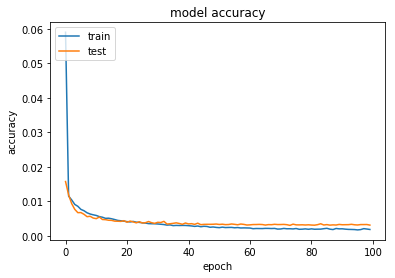

In [603]:
plt.plot(faces_run.history['loss'])
plt.plot(faces_run.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [604]:
model.load_weights('saved_models/face.best.from_scratch.hdf5')

In [556]:
#Prepare test set
df_test = read_csv(os.path.expanduser(FTEST))
df_test['Image'] = df_test['Image'].apply(lambda im: np.fromstring(im, sep=' '))
X_test = np.vstack(df_test['Image'].values)
X_test = X_test.astype(np.float32)
X_test = X_test.reshape(-1, 96, 96, 1)

The test data provided is not labled, but I wanted to plot a sample and get a feel to how good/bad the model predicts nose tips on unseen data.

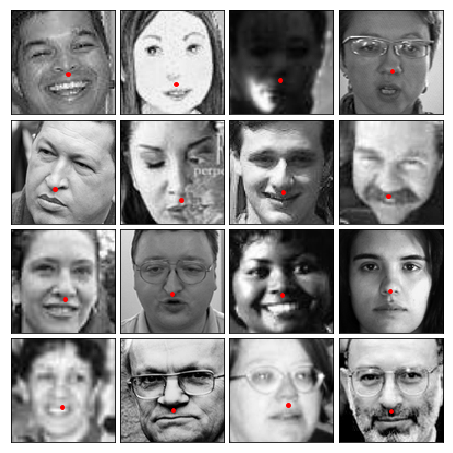

In [605]:
def plot_sample(x, y_pred, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    #axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='o', s=15,c='y')
    axis.scatter(y_pred[0] * 48 + 48, y_pred[1] * 48 + 48, marker='o', s=15,c='r')

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X_test[i], model.predict(X_test[i].reshape(-1,96,96,1))[0], ax)

plt.show()



<img src="http://i0.kym-cdn.com/photos/images/newsfeed/000/181/367/closeenough.png?1317606898" width="250">

This model can be improved, but It's close enough.
___


<a id='step3'></a>
## Step 3: Putting it all together
Now that I have a model to predict where the nose tip is, I can take a look on how to do that on the provided human images.   
I will need to identify the face in the image, crop the face, detect the nose and resclae the nose coordinates back to the original image proportions.

Left: 76 Top: 72 Right: 175 Bottom: 170, height: 99 Confidence: 1.06510925293
[49.789177 69.33853 ]


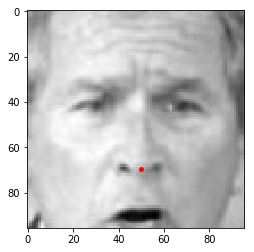

In [644]:
import dlib

cnn_face_detector = dlib.cnn_face_detection_model_v1('mmod_human_face_detector.dat')
#load human image so I can look at provided images
humans = np.array(glob("lfw/*/*"))
a_human_img = cv2.imread(humans[1022])
#detect face for the nose detection
human_img_faces = cnn_face_detector(a_human_img, 1)
for face in human_img_faces:
    print("Left: {} Top: {} Right: {} Bottom: {}, height: {} Confidence: {}".format(
            face.rect.left(), face.rect.top(), face.rect.right(), face.rect.bottom(), face.rect.height(), face.confidence))
    #crop face using face detection rectangle
    face_img = a_human_img[face.rect.top():face.rect.bottom(), face.rect.left():face.rect.right(), :]
    #resize and reshape to fit the model structure
    face_resized = cv2.resize(face_img, (96, 96))
    face_gray = cv2.cvtColor(face_resized, cv2.COLOR_RGB2GRAY)/ 255.
    face_gray_reshape = face_gray[np.newaxis, :, :, np.newaxis]

    nose_xy = model.predict(face_gray_reshape)[0] * 48 + 48
    print(nose_xy)
    plt.figure()
    plt.imshow(face_gray, cmap='gray')
    plt.scatter(nose_xy[0], nose_xy[1] , marker='o', s=15,c='r')

    plt.show()

random image nose detection is looking good!
Let's put that code in a couple of routines for convinience.    
This routine also changes the detected nose coordinates to original image.

In [658]:
def nose_locator(human_image):
    #predict face box
    human_img_faces = cnn_face_detector(human_image, 1)
    nose_coord_list=[]
    for face in human_img_faces:
        #slice out the face
        face_img = human_image[face.rect.top():face.rect.bottom(), face.rect.left():face.rect.right(), :]
        #resize and normalize the same way the model was trained 
        face_resized = cv2.resize(face_img, (96, 96))
        face_gray = cv2.cvtColor(face_resized, cv2.COLOR_RGB2GRAY)/ 255.
        face_gray_reshape = face_gray[np.newaxis, :, :, np.newaxis]
        #Predict using the model
        nose_xy = model.predict(face_gray_reshape)[0] * 48 + 48
        
        #re-scale nose coordinates to the bigger image
        rescaled_x = face.rect.left() + (nose_xy[0]*(face.rect.width()/96))
        rescaled_y = face.rect.top() + (nose_xy[1]*(face.rect.height()/96))
        nose_coord_list.append([rescaled_x, rescaled_y])
    return nose_coord_list

[121.43808980782826, 148.20516403516132]


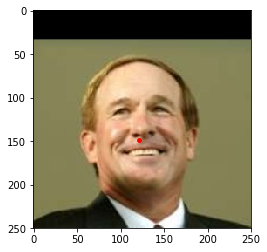

In [665]:
from glob import glob

humans = np.array(glob("lfw/*/*"))
a_human_img = cv2.imread(humans[6])
coords = nose_locator(a_human_img.copy())[0]
print(coords)
plt.figure()
plt.imshow(cv2.cvtColor(a_human_img, cv2.COLOR_BGR2RGB))
plt.scatter(coords[0], coords[1], marker='o', s=15,c='r')

plt.show()

The detection is a little off, but it is OK and fits the original image.   
Finally, I'll write a routine to overlay the dog nose 

In [676]:
def add_dog_nose(a_human_image, nose_tip_x, nose_tip_y):
    x_box = int(round(nose_tip_x - nose_img.shape[1]//2,0))
    y_box = int(round(nose_tip_y - nose_img.shape[0]//2,0))
    x_size = x_box + nose_img.shape[1]
    y_size = y_box + nose_img.shape[0]
    a_human_image[y_box:y_size, x_box:x_size] = np.where(nose_img == 0, a_human_image[y_box:y_size, x_box:x_size], nose_img)
    return a_human_image

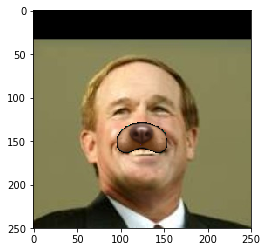

In [678]:
a_human_img = cv2.cvtColor(cv2.imread(humans[6]), cv2.COLOR_BGR2RGB)
coords = nose_locator(a_human_img)[0]
human_dog = add_dog_nose(a_human_img, coords[0], coords[1])
plt.imshow(human_dog)
plt.show()

<img src="http://i0.kym-cdn.com/entries/icons/original/000/000/745/success.jpg" width=250>
Great success!
____
<a id='step4'></a>
## Step 4: Augmenting images with keypoints
It took me some time to make that CNN above to work as expected. I did not feed the data properly into the model which caused the model to overfit quickly.   
In an effort to fight overfitting, I wanted to augment the training data but augmenting images with their keypoints is not trivial in Keras.   
Instead, I found the [imgaug library](https://github.com/aleju/imgaug) that helps augment images and keypoints which is what I was looking for.   
This will require using a custom generator for Keras model fitting.

In [682]:
#Let the generator scale pixels and keypoints
X = np.vstack(df['Image'].values)
X = X.astype(np.float32)
X = X.reshape(-1, 96, 96, 1)
y = df[['nose_tip_x','nose_tip_y']].values
X, y = shuffle(X, y, random_state=42)  # shuffle train data
y = y.astype(np.float32)

In [683]:
def generator(features, labels, seq, img_w=96, img_h=96, img_ch=1, no_kpi=1, batch_size=32):
    while True:
        batch_indexes = np.random.randint(features.shape[0], size=batch_size)
        batch_features = features[batch_indexes,:]
        batch_lables = labels[batch_indexes,:]
        keypoints = [ia.KeypointsOnImage([ia.Keypoint(x=k[0],y=k[1])], shape=(img_w,img_h)) for k in batch_lables]

        seq_det = seq.to_deterministic()
        image_aug = seq_det.augment_images(batch_features)
        keypoints_aug = seq_det.augment_keypoints(keypoints)
        #rescale target to be between [-1,1]
        scaled_aug = [[(kp.keypoints[0].x - 48) / 48., (kp.keypoints[0].y - 48) / 48. ] for kp in keypoints_aug]
        #rescale image to be between [0,1]
        image_aug = image_aug/255
        yield (image_aug, scaled_aug)

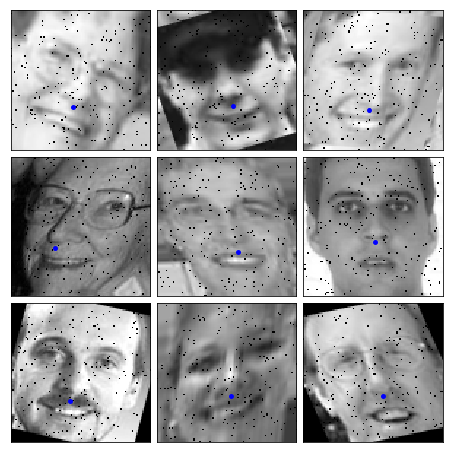

In [684]:
#plot augmented images to see how it works
#http://imgaug.readthedocs.io/en/latest/source/examples_keypoints.html#a-simple-example

seq = iaa.Sequential([iaa.Fliplr(0.5), 
                      iaa.Affine(rotate=(-20,20), shear=(-20, 20), mode=ia.ALL), 
                      iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
                      iaa.Dropout(0.02, name="Dropout"),
                      iaa.Multiply((0.8, 1.2))])

for X_batch, y_batch in generator(X, y, seq,batch_size=9):
    fig = plt.figure(figsize=(6, 6))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(0, 9):
        ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_batch[i]), cmap='gray')
        ax.scatter(y_batch[i][0]*48+48, y_batch[i][1]*48+48, marker='o', s=15,c='b')
    plt.show()
    break     

In [685]:
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint  

batch_size=64
epochs=300
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.20, random_state=42)
        
checkpointer = ModelCheckpoint(filepath='saved_models/face2.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

faces_run = model.fit_generator(generator = generator(X_train, y_train, seq),
                    steps_per_epoch = X_train.shape[0]//batch_size,
                    validation_data = generator(X_validation, y_validation, seq),
                    validation_steps = X_validation.shape[0]//batch_size,
                    epochs=epochs,
                    callbacks=[checkpointer],
                    verbose=1)

Epoch 1/300
88/88 [==============================] - 5s 57ms/step - loss: 0.1218 - val_loss: 0.0275
Epoch 2/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0212 - val_loss: 0.0294
Epoch 3/300
88/88 [==============================] - 5s 55ms/step - loss: 0.0199 - val_loss: 0.0183
Epoch 4/300
88/88 [==============================] - 5s 55ms/step - loss: 0.0184 - val_loss: 0.0129
Epoch 5/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0178 - val_loss: 0.0136
Epoch 6/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0163 - val_loss: 0.0156
Epoch 7/300
88/88 [==============================] - 5s 51ms/step - loss: 0.0159 - val_loss: 0.0137
Epoch 8/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0162 - val_loss: 0.0139
Epoch 9/300
88/88 [==============================] - 5s 54ms/step - loss: 0.0164 - val_loss: 0.0122
Epoch 10/300
88/88 [==============================] - 5s 54ms/step - loss: 0.0153 - val_loss: 0.0109

88/88 [==============================] - 5s 55ms/step - loss: 0.0119 - val_loss: 0.0079
Epoch 38/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0122 - val_loss: 0.0103
Epoch 39/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0120 - val_loss: 0.0084
Epoch 40/300
88/88 [==============================] - 5s 51ms/step - loss: 0.0116 - val_loss: 0.0093
Epoch 41/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0121 - val_loss: 0.0090
Epoch 42/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0118 - val_loss: 0.0090
Epoch 43/300
88/88 [==============================] - 5s 56ms/step - loss: 0.0108 - val_loss: 0.0078
Epoch 44/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0113 - val_loss: 0.0091
Epoch 45/300
88/88 [==============================] - 5s 51ms/step - loss: 0.0110 - val_loss: 0.0101
Epoch 46/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0109 - val_loss: 0.0095
Epo

Epoch 76/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0092 - val_loss: 0.0074
Epoch 77/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0092 - val_loss: 0.0071
Epoch 78/300
88/88 [==============================] - 5s 55ms/step - loss: 0.0089 - val_loss: 0.0062
Epoch 79/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0086 - val_loss: 0.0069
Epoch 80/300
88/88 [==============================] - 5s 56ms/step - loss: 0.0095 - val_loss: 0.0058
Epoch 81/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 82/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0088 - val_loss: 0.0085
Epoch 83/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0090 - val_loss: 0.0075
Epoch 84/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0085 - val_loss: 0.0073
Epoch 85/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0083 - val_los

Epoch 115/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0078 - val_loss: 0.0065
Epoch 116/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0071 - val_loss: 0.0062
Epoch 117/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0072 - val_loss: 0.0065
Epoch 118/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0072 - val_loss: 0.0055
Epoch 119/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0078 - val_loss: 0.0063
Epoch 120/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0071 - val_loss: 0.0056
Epoch 121/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0068 - val_loss: 0.0061
Epoch 122/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0070 - val_loss: 0.0064
Epoch 123/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0073 - val_loss: 0.0050
Epoch 124/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0069

88/88 [==============================] - 5s 54ms/step - loss: 0.0070 - val_loss: 0.0048
Epoch 155/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0069 - val_loss: 0.0052
Epoch 156/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0064 - val_loss: 0.0060
Epoch 157/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0068 - val_loss: 0.0050
Epoch 158/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0074 - val_loss: 0.0059
Epoch 159/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0061 - val_loss: 0.0055
Epoch 160/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0064 - val_loss: 0.0052
Epoch 161/300
88/88 [==============================] - 5s 51ms/step - loss: 0.0065 - val_loss: 0.0056
Epoch 162/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0066 - val_loss: 0.0051
Epoch 163/300
88/88 [==============================] - 5s 51ms/step - loss: 0.0068 - val_loss: 0

Epoch 195/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0058 - val_loss: 0.0053
Epoch 196/300
88/88 [==============================] - 5s 55ms/step - loss: 0.0064 - val_loss: 0.0042
Epoch 197/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0058 - val_loss: 0.0043
Epoch 198/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0058 - val_loss: 0.0054
Epoch 199/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0069 - val_loss: 0.0056
Epoch 200/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0064 - val_loss: 0.0051
Epoch 201/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0069 - val_loss: 0.0057
Epoch 202/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0067 - val_loss: 0.0056
Epoch 203/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0064 - val_loss: 0.0052
Epoch 204/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0062

Epoch 235/300
88/88 [==============================] - 5s 51ms/step - loss: 0.0058 - val_loss: 0.0057
Epoch 236/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0063 - val_loss: 0.0052
Epoch 237/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0061 - val_loss: 0.0048
Epoch 238/300
88/88 [==============================] - 5s 51ms/step - loss: 0.0059 - val_loss: 0.0053
Epoch 239/300
88/88 [==============================] - 5s 51ms/step - loss: 0.0063 - val_loss: 0.0074
Epoch 240/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0062 - val_loss: 0.0048
Epoch 241/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0062 - val_loss: 0.0041
Epoch 242/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0056 - val_loss: 0.0048
Epoch 243/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0062 - val_loss: 0.0056
Epoch 244/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0062

Epoch 275/300
88/88 [==============================] - 5s 51ms/step - loss: 0.0065 - val_loss: 0.0047
Epoch 276/300
88/88 [==============================] - 5s 51ms/step - loss: 0.0060 - val_loss: 0.0054
Epoch 277/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0060 - val_loss: 0.0040
Epoch 278/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 279/300
88/88 [==============================] - 5s 51ms/step - loss: 0.0060 - val_loss: 0.0046
Epoch 280/300
88/88 [==============================] - 4s 51ms/step - loss: 0.0055 - val_loss: 0.0047
Epoch 281/300
88/88 [==============================] - 5s 51ms/step - loss: 0.0060 - val_loss: 0.0052
Epoch 282/300
88/88 [==============================] - 5s 52ms/step - loss: 0.0058 - val_loss: 0.0046
Epoch 283/300
88/88 [==============================] - 5s 51ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 284/300
88/88 [==============================] - 5s 51ms/step - loss: 0.0056

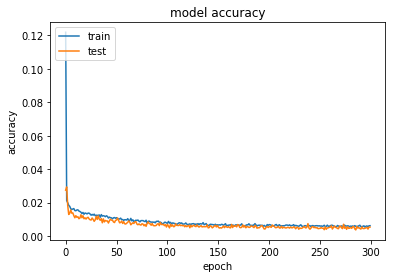

In [686]:
plt.plot(faces_run.history['loss'])
plt.plot(faces_run.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [687]:
model.load_weights('saved_models/face2.best.from_scratch.hdf5')

This model reached a lower validation accuracy with 300 epochs, but since the data is augmented it very well generalize better.   
Let's watch the same test sample as the first model

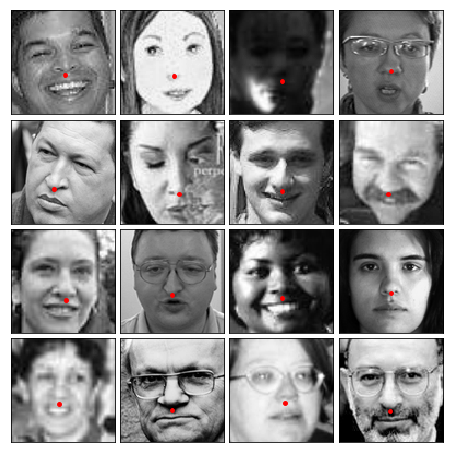

In [688]:
def plot_sample(x, y_pred, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    #axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='o', s=15,c='y')
    axis.scatter(y_pred[0] * 48 + 48, y_pred[1] * 48 + 48, marker='o', s=15,c='r')

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X_test[i], model.predict(X_test[i].reshape(-1,96,96,1))[0], ax)

plt.show()